## Juego del Prisionero con retraso en la difusión de la información

En este trabajo práctico vamos a analizar una variante del [Dilema del Prisionero](https://es.wikipedia.org/wiki/Dilema_del_prisionero).

[Existen múltiples modificaciones al juego](http://systems-sciences.uni-graz.at/etextbook/gametheory/prisonersdilemma.html). Una de las ramas estudiadas es la del juego iterativo: se juegan sucesivas veces, y en cada partida los agentes tienen cierta memoria de lo que hizo el otro en el pasado. Existen también estudios hechos con múltiples agentes, varias estrategias en el tiempo y distintas topologías (quién juega contra quién).

En nuestra variante la grilla representa una prisión y los prisioneros se mueven de forma aleatoria por ella, y al encontrarse con otro prisionero deciden o no traicionarlo.
Al ocurrir una traición, se aumenta la condena del traicionado en una cierta cantidad de tiempo, pero la víctima se enterará de que fue traicionado un determinado tiempo después.

La mejor solución es Quid-Pro-Quo, ya que fue estudiado que ésta reduce la dispersión de los tiempos de condena, pero esta se basa en la inmediatez con la que un prisionero conoce que otro lo delató o traicionó. En una situación de esparcimiento de información falsa o no comprobable (como esta)
con objetivos de manipulación, para conseguir una reducción de la condena un alcaide es informado de que alguien traiciona a alguien y éste decide que hace con la información. Esto es lo que deseamos modelar.

### Modelo conceptual

En general nuestro modelo se explica por:

- un tamaño de la grilla
- una cantidad de prisioneros inicial (`N`) con sus respectivas condenas iniciales
- encuentros entre prisioneros que con probabilidad `1/p` desata una traición informada al oponente con retraso `m,..,M` iteraciones (equiprobable)
- encuentros entre prisioneros que ya saben que fueron buchoneados por su oponente en algún instante anterior y entonces siempre traicionan (Quid-Pro-Quo) con retraso de información de `m,..,M` iteraciones (equiprobable)
- el paso del tiempo
- cuánto tiempo se agrega a la condena cuando se es traicionado (`c`)

Si bien sobre esta variante introdujimos algunas particularidades:

- si un prisionero todavía no sabe que fue buchoneado por otro que se vuelve a encontrar, entonces la condena se aumenta pero se toma el mínimo retraso de información, entre la nueva traición y la anterior
- las condenas nunca se reducen
- no se distingue entre traición-traición y traición-no traición (a diferencia del Dilema original cuya condena agregada es menor en el primer caso)
- si la condena es 0, el prisionero inmediatamente sale de la prisión

Con el objetivo de entender el modelo, experimentaremos con distintos valores de los parámetros:
- `c`: agregado leve (1 turno), moderado (10 turnos), grave (50 turnos)
- `p`: probabilidad baja (0.2), media (0.5), alta (0.8)
- `m` y `M`: retraso rápido (0 a 5 turnos), variado (0 a 10 turnos), medio (5 a 10 turnos), largo (10 a 20 turnos)

Los prisioneros inician con una condena aleatoria (distribución normal, con media 50 turnos y desvio estándar 10 turnos), en posiciones iniciales seleccionadas de forma aleatoria. Para cara experimento, corremos 15 repeticiones con condenas y posiciones distintas.

El movimiento se realiza de forma aleatoria: en cada turno, un prisionero se mueve a la posición a la que está mirando (si puede). Al moverse, elige una nueva dirección a la que mirar, en la vecindad de von Neumann. Para evitar colisiones (dos prisioneros moviéndose a la misma celda), el autómata celular utiliza una vecindad de von Neumann extendida.

Definimos un conflicto cuando dos prisioneros se encuentran en celdas vecinas (en la vecindad de von Neumann) y ambos se miran respectivamente. Cada vez que sucede esto, ambos prisioneros pueden ser buchoneados por el otro, siguiendo las reglas nombradas anteriormente (y formalizadas en la próxima sección).

### Reglas Cell-DEVS

Para esto usamos CD++ y un archivo ``.ma`` generado de forma dinámica, pero cuyas bases son las reglas de:

- _Movimiento_: mueven a un prisionero en la dirección a la que está mirando si el casillero está libre, además hacen que pase el tiempo.
- _Eliminación_: remueven a un prisionero que se movió de lugar del casillero anterior.
- _Buchoneo_: determinan si mi oponente me buchonea y cuanto tiempo pasa hasta que me entere. Se usa 0 como código de que fuí traicionado, -1 para no haber sido traicionado y n > 0 como la cantidad de iteraciones que faltan para saber que me traicionaron.

Se codifica una tupla en la que:
- Lugar 0-ésimo: identificador del prisionero
- Lugar 1-ésimo: dirección (de mirada)
- Lugar 2-ésimo: duración de la condena
- Lugar i+3-ésimo: 0 si el prisionero i me traicionó y lo sé, n > 0 si faltan n iteraciones para saber que el prisionero i me traicinó y -1 si nunca fue traicionado por éste.

NOTA: las reglas y sus condiciones se encuentras comentadas para mayor claridad.

In [1]:
%%bash

tail -n +20 model/prisioneros.ma.j2 | head -n 55

% Si termina la condena, desaparece
rule : 0 100 {(0,0)!2<=100}

% Reglas de movimiento si no hay enfrentamiento

% Reglas de moverme
rule : {
    [
        (0,-1)!0,
        randInt(3) + 1,
        (0,-1)!2 - 100,
{% for pr in prisioners %}
        if((0,-1)!{{ loop.index0 + 3 }} > 0, (0,-1)!{{ loop.index0 + 3 }} - 1 , (0,-1)!{{ loop.index0 + 3 }}){% if not  loop.last %},{% endif %}
{% endfor %}
    ]
} 100 {(0,0)=0 and (0,-1)!1=1 and (0,-1)!2>100}

rule : {
    [
        (-1,0)!0,
        randInt(3) + 1,
        (-1,0)!2 - 100,
{% for pr in prisioners %}
        if((-1,0)!{{ loop.index0 + 3 }} > 0, (-1,0)!{{ loop.index0 + 3 }} - 1 , (-1,0)!{{ loop.index0 + 3 }}){% if not loop.last %},{% endif %}
{% endfor %}
    ]
} 100 {(0,0)=0 and (-1,0)!1=2 and (-1,0)!2>100}

rule : {
    [
        (0,1)!0,
        randInt(3) + 1,
        (0, 1)!2 - 100,
{% for pr in prisioners %}
        if((0,1)!{{ loop.index0 + 3 }} > 0, (0,1)!{{ loop.index0 + 3 }} - 1 , (0,1)!{{ loop.index0 + 3 }}){% if not lo

In [2]:
%%bash

# Mostramos la regla de buchoneo solamente para uno de los 4 casos.
# los otros casos son similares

tail -n +80 model/prisioneros.ma.j2 | head -n 30

% regla buchoneo (0,1)
rule : {
    [
        (0,0)!0,
        randInt(3) + 1, % elijo nueva direccion
        (0,0)!2 + {{ added_sentence }}, % te buchonearon
{% for pr in prisioners %}
        if(
            (0,1)!0 = {{ loop.index }}, % es el oponente {{ loop.index }}
            if((0,0)!{{ loop.index0 + 3 }} = -1, randInt({{ max_delay - min_delay }}) + {{ min_delay }}, min((0,0)!{{ loop.index0 + 3 }}, randInt({{ max_delay - min_delay }}) + {{ min_delay }})), % si ya me buchoneo (lo sepa o no)
            if((0,0)!{{ loop.index0 + 3 }} > 0, (0,0)!{{ loop.index0 + 3 }} - 1 , (0,0)!{{ loop.index0 + 3 }}) % pasa el tiempo
        ){% if not loop.last %},{% endif %}
{% endfor %}
    ]
} 100 {
    (0,0)!1=1 and (0,1)!1=3 % me estoy mirando
    and
    (
{% for pr in prisioners %}
        (
            (0,0)!0 = {{ loop.index }} % soy el {{ loop.index }}
            and
            (0,1)!{{ loop.index0 + 3 }} = 0 % obligatoriamente me buchonea porque ya se entero de que lo buchonee
    

In [3]:
%%bash

tail -n +204 model/prisioneros.ma.j2 | head -n 30

% regla de NO buchoneo
rule : {
    [
        (0,0)!0,
        randInt(3) + 1, % elijo nueva direccion
        (0,0)!2 - 100, % no te buchonearon
{% for pr in prisioners %}
        if((0,0)!{{ loop.index0 + 3 }} > 0, (0,0)!{{ loop.index0 + 3 }} - 1 , (0,0)!{{ loop.index0 + 3 }}){% if not loop.last %},{% endif %}
{% endfor %}
    ]
} 100 {
    (
        (0,0)!1=1 and (0,1)!1=3 % me estoy mirando - regla (0,1)
    )
    or
    (
        (0,0)!1=3 and (0,-1)!1=1 % me estoy mirando - regla (0,-1)
    )
    or
    (
        (0,0)!1=2 and (1,0)!1=4 % me estoy mirando - regla (1,0)
    )
    or
    (
        (0,0)!1=4 and (-1,0)!1=2 % me estoy mirando - regla (-1,0)
    )
    % si esta regla va despues de las reglas de buchoneo
    % si llegue aca (por el orden de las reglas), no me buchonearon
}



In [4]:
%%bash

tail -n +234 model/prisioneros.ma.j2

% regla default es que pasa el tiempo pero no se mueve
rule : 0 100 { (0,0) = 0 }
rule : {
    [
        (0,0)!0,
        (0,0)!1,
        (0,0)!2 - 100,
{% for pr in prisioners %}
        if((0,0)!{{ loop.index0 + 3 }} > 0, (0,0)!{{ loop.index0 + 3 }} - 1 , (0,0)!{{ loop.index0 + 3 }}){% if not loop.last %},{% endif %}
{% endfor %}
    ]
} 100 { t }


### Experimentos

In [5]:
from log_loader import load_log
from plots import agents_count_stats, plot_uncertainty, total_life_times, plot_histogram, proba_text, log_index, indices
# log_index es un diccionario de id de experimento a (c, (m, M), p)

In [6]:
def search_experiment_results(c, delay, p):
    first_experiment = min([i for i, v in log_index.items() if v == (c, delay, p)])
    experiments_index = range(first_experiment, first_experiment + 15)
    # print(experiments_index)
    assert len(experiments_index) == 15
    # print([indices[i] for i in experiments_index])
    return [load_log(f"model/log-{indices[i]}/log.log01") for i in experiments_index]

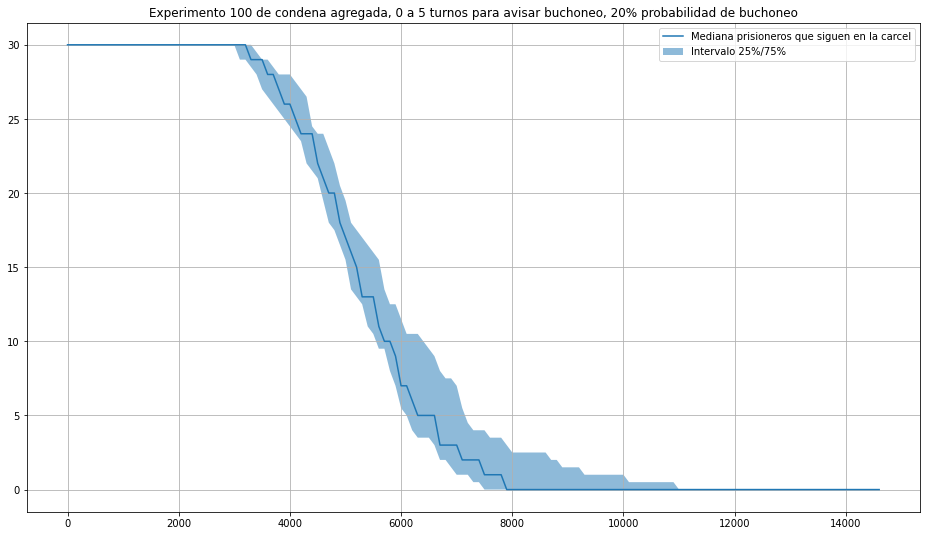

In [7]:
log_dfs = search_experiment_results(100, (0, 5), proba_text(20))
stats = agents_count_stats(log_dfs)
plot_uncertainty(stats, 'Experimento 100 de condena agregada, 0 a 5 turnos para avisar buchoneo, 20% probabilidad de buchoneo')

In [ ]:
# La sumatoria concatena listas
life_times = sum([total_life_times(log_df) for log_df in log_dfs], [])

# Histograma del tiempo de condena total de los agentes con distintas corridas aleatorizadas
plot_histogram(life_times, 'Tiempo de condena total')

### Tareas

#### TOBI

- [ ] Buchoneos por configuracion (heatmap de a dos variables)
- [ ] Correlacion entre variables y buchoneos (regresion lineal)
- [ ] Corrleacion entre veces que buchoneaste y veces que fuiste buchoneado (recta)

##### VALEN

- [ ] Buchoneos en funcion del tiempo (comparar barplots)
- [ ] Comparar buchoneos segun retardo alto con retardo bajo segun el tiempo (en forma de rectas)
- [ ] Para ver si hay distintos momentos (pocos buchonean vs todos buchonean xq saben que fueron delatados) segun el retardo